In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
b = 400
h = 450
As = 1407
As1 = 1206
d = 410
d1 = 40
d2 = 40

fck = 25
fyk = 450
fyk1 = 450
Ec = 31475.806
Es = 200000

ese = 1.9565/1000
ese1 = 1.9565/1000
esu = 10/1000 # campo 1 e 2
ecu = 3.5/1000
ec = 3.5/1000
ec2 = 2/1000



In [5]:
xi23 = ecu/(ecu + esu)
xi23

0.25925925925925924

In [22]:
xi34 = ecu/(ecu + ese1)
xi34

0.6414368184733804

In [4]:
# NO
xi2a2b = (d2/d * esu - ese1) / (esu -ese1) 
xi2a2b

-0.12194818721979721

In [1]:
def storeToDict(dic,strainRange,N,M,nu,mu):
    dic[strainRange]["N"] = N
    dic[strainRange]["M"] = M
    dic[strainRange]["nu"] = nu
    dic[strainRange]["mu"] = mu
    

In [134]:
def strainDistribution(As,As1):
    # per store to dict 
    global N
    global M
    global nu
    global mu
    global xi
    global x
    
    # Two concatenated dictionaries to store all values for each stain range (1-6)
    dic = {}
    fcd = fck * 0.85 / 1.5
    fyd = fyk/1.15 
    
    # --------------------------------------------------------------------
    # ------------------------------ CAMPO 2 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "2"
    dic[strainRange]={}

    xi = np.linspace(0,xi23,130)
    x = xi * d
    es1 = - (esu * (x - d2)) /(d - x)

    fyd1 = []
    for i in range(len(es1)):
        if abs(es1[i]) > ese1 and es1[i] > 0:
            fyd1.append(fyk1/1.15)
        elif abs(es1[i]) > ese1 and es1[i] < 0:
            fyd1.append(-fyk1/1.15)
        else:
            fyd1.append(Es * es1[i])
    fyd1 = np.array(fyd1)        

    psi = []
    # n = 2 C<C50/60
    for i in range(len(xi)):
        if xi[i] < 1/6:
            psi.append(xi[i]/(1-xi[i]) * esu/(3 * ec2**2) * (3 * ec2 - xi[i]/(1-xi[i]) * esu))
        else:
            psi.append(1 - ( ec2*(1-xi[i]) ) / ( 3*esu*xi[i] ))
    psi = np.array(psi)  

    lamb = [] #lambda
    # n = 2 C<C50/60
    for i in range(len(xi)):
        if xi[i] < 1/6:
            lamb.append( ( 4*ec2 - esu*xi[i]/(1-xi[i]) ) / ( 4*(3*ec2 - esu*xi[i]/(1-xi[i])) ) )
        else:
            lamb.append( ( (6*esu**2 + 4*esu*ec2 +  ec2**2)*xi[i]**2 - 2*ec2**2*xi[i] + ec2**2 - 4*esu*ec2*xi[i] ) / ( 4*esu*xi[i]*((3*esu+ec2)*xi[i] - ec2 )) )        
    lamb[0]=0
    lamb = np.array(lamb) 

    N = b * psi * x * fcd  - fyd1*As1 - fyd * As 
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    
    # --------------------------------------------------------------------
    # ------------------------------ CAMPO 3 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "3"
    dic[strainRange]={}
    
    fcd = fck * 0.85 / 1.5
    fyd = fyk/1.15

    xi = np.linspace(xi23,xi34,100)
    x = xi * d

    es1 = - ecu * (x - d2) / x

    fyd1 = -fyk1/1.15  

    psi = 17/21 # 0.8095238095238095

    lamb = 99/238 # 0.4159663865546219

    # solo campo 3B. Da capire il 3A perché non lo considera!
    
    N = b * psi * x * fcd  - fyd1*As1 - fyd * As  
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    
    # --------------------------------------------------------------------
    # ------------------------------ CAMPO 4 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "4"
    dic[strainRange]={}
    
    fcd = fck * 0.85 / 1.5

    xi = np.linspace(xi34,1,100)
    x = xi * d

    es1 = - ecu * (x - d2) / x
    es = ecu * (d-x) / x

    fyd1 = -fyk1/1.15  
    fyd = Es*es

    psi = 17/21 # 0.8095238095238095

    lamb = 99/238 # 0.4159663865546219

    # solo campo 3B. Da capire il 3A perché non lo considera!
    
    N = b * psi * x * fcd  - fyd1*As1 - fyd * As  
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    
    # --------------------------------------------------------------------
    # ------------------------------ CAMPO 5 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "5"
    dic[strainRange]={}
    
    fcd = fck * 0.85 / 1.5

    xi = np.linspace(1,1+d1/d,20)
    x = xi * d

    es1 = - ecu * (x - d2) / x
    es = - ecu * (d-x) / x

    fyd1 = -fyk1/1.15  
    fyd = - Es*es

    psi = 17/21 # 0.8095238095238095

    lamb = 99/238 # 0.4159663865546219

    # solo campo 3B. Da capire il 3A perché non lo considera!
    
    N = b * psi * x * fcd  - fyd1*As1 - fyd * As  
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    # ------------------------------------
    
    return dic

In [135]:
# Above and below x axis: invert steel areas and change M sign in plotting function 
MN_up = strainDistribution(As,As1)
MN_down = strainDistribution(As1,As) 
MN_up['5']

{'N': array([2352706.69427191, 2367395.58892233, 2382033.33828559,
        2396620.71826996, 2411158.48916796, 2425647.39604721,
        2440088.16912967, 2454481.52415952, 2468828.16276023,
        2483128.77278107, 2497384.02863346, 2511594.59161754,
        2525761.11023928, 2539884.22051833, 2553964.54628718,
        2568002.6994816 , 2581999.28042294, 2595954.87809234,
        2609870.0703973 , 2623745.42443064]),
 'M': array([1.89720240e+08, 1.87659810e+08, 1.85591928e+08, 1.83516450e+08,
        1.81433235e+08, 1.79342145e+08, 1.77243046e+08, 1.75135804e+08,
        1.73020291e+08, 1.70896378e+08, 1.68763941e+08, 1.66622859e+08,
        1.64473010e+08, 1.62314276e+08, 1.60146544e+08, 1.57969699e+08,
        1.55783631e+08, 1.53588230e+08, 1.51383389e+08, 1.49169004e+08]),
 'nu': array([1.01264277, 1.0189651 , 1.02526543, 1.03154407, 1.03780136,
        1.04403762, 1.05025316, 1.05644829, 1.06262331, 1.06877852,
        1.07491422, 1.08103067, 1.08712817, 1.09320698, 1.09926738,


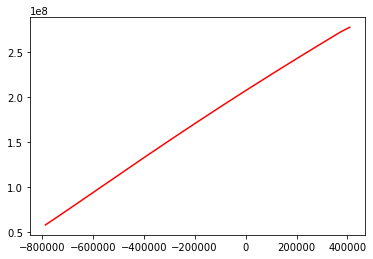

In [40]:
plt.plot(MN_up["2"]["N"],MN_up["2"]["M"],color="red")

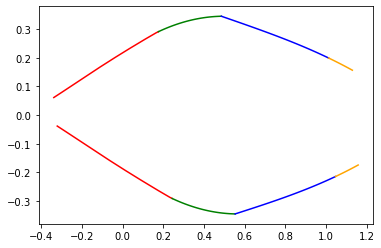

In [136]:
plt.plot(MN_up["2"]["nu"],MN_up["2"]["mu"],color="red")
plt.plot(MN_down["2"]["nu"],-MN_down["2"]["mu"],color="red")
plt.plot(MN_up["3"]["nu"],MN_up["3"]["mu"],color="green")
plt.plot(MN_down["3"]["nu"],-MN_down["3"]["mu"],color="green")
plt.plot(MN_up["4"]["nu"],MN_up["4"]["mu"],color="blue")
plt.plot(MN_down["4"]["nu"],-MN_down["4"]["mu"],color="blue")
plt.plot(MN_up["5"]["nu"],MN_up["5"]["mu"],color="orange")
plt.plot(MN_down["5"]["nu"],-MN_down["5"]["mu"],color="orange")

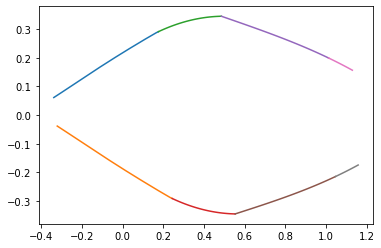

In [166]:
def interactionDiagram(dic_up,dic_down):
    for i in range(2,6): #(1,7) when finisched
        i = str(i)
        plt.plot(dic_up[i]["nu"],dic_up[i]["mu"],dic_down[i]["nu"],-dic_down[i]["mu"])

interactionDiagram(MN_up,MN_down)        

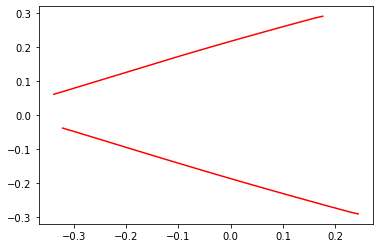

In [146]:
plt.plot(MN_up["2"]["nu"],MN_up["2"]["mu"],
         MN_down["2"]["nu"],-MN_down["2"]["mu"],color="red")

In [142]:
(ecu-ec2)*(d+d1)/ecu

192.85714285714286

In [ ]:
fcd = fck * 0.85 / 1.5

t= 3/7 * (d+d1) # C<C50/60 (ecu-ec2)*(d+d1)/ecu

xi = np.linspace(1+d1/d,20)
x = xi * d

es1 = - ecu * (x - d2) / x
es = - ecu * (d-x) / x

fyd1 = -fyk1/1.15  
fyd = - Es*es

psi = 17/21 # 0.8095238095238095

lamb = 99/238 # 0.4159663865546219

# solo campo 3B. Da capire il 3A perché non lo considera!

N = b * psi * x * fcd  - fyd1*As1 - fyd * As  
M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
nu = N/(b*d*fcd)
mu = M/(b*d**2*fcd)